### RCC85 time series plot

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
import xarray as xr
import geopandas as gpd
import pandas as pd
# requires cartopy to be installed
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xesmf as xe 
import sys
import os
import dask

In [27]:
models = ["BNU-ESM", "CNRM-CM5", "CSIRO-Mk3-6-0", "CanESM2", "GFDL-ESM2G", "GFDL-ESM2M", "HadGEM2-CC365", "HadGEM2-ES365", "IPSL-CM5A-LR",
         "IPSL-CM5A-MR", "IPSL-CM5B-LR", "MIROC-ESM-CHEM", "MIROC-ESM", "MIROC5", "bcc-csm1-1-m", "MRI-CGCM3", "bcc-csm1-1", "inmcm4"]

In [31]:
# data availaibility issues for BNU-ESM, amd bcc-csm-1. so these models are not included for rcp8.5 norcal
models = ["CNRM-CM5", "CSIRO-Mk3-6-0", "CanESM2", "GFDL-ESM2G", "GFDL-ESM2M", "HadGEM2-CC365", "HadGEM2-ES365", "IPSL-CM5A-LR",
         "IPSL-CM5A-MR", "IPSL-CM5B-LR", "MIROC-ESM-CHEM", "MIROC-ESM", "MIROC5", "bcc-csm1-1-m", "MRI-CGCM3", "inmcm4"]

In [32]:
len(models)

16

CNRM-CM5
CSIRO-Mk3-6-0
CanESM2
GFDL-ESM2G
GFDL-ESM2M
HadGEM2-CC365
HadGEM2-ES365
IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC-ESM-CHEM
MIROC-ESM
MIROC5
bcc-csm1-1-m
MRI-CGCM3
inmcm4
BNU-ESM
bcc-csm1-1


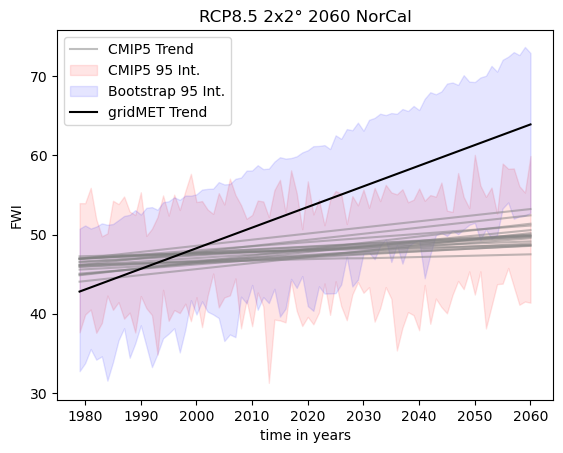

In [33]:
# The following until the # line is all just plotting the original trend, and slope etc. 
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'
    # Save the dataset to a .nc file
annual_mean = xr.open_dataset(filein)
lon_max = -121
lon_min = -123
lat_min = 38.5
lat_max = 40.5

annual_mean = annual_mean.where((annual_mean.lon >= lon_min) & (annual_mean.lon <= lon_max) & (annual_mean.lat >= lat_min) & (annual_mean.lat <= lat_max), drop=True)
annual_mean = annual_mean.groupby('time.year').mean(dim='time')

spatial_aggregate = annual_mean.mean(dim=['lon'])
spatial_aggregate = spatial_aggregate.mean(dim=['lat'])
# in this case spatial aggregate is the data I have, now I need to fit linear regression 
fwi = spatial_aggregate
poly_coeffs = fwi.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=fwi["year"], coeffs=poly_coeffs)
trend_slope = poly_coeffs.sel(degree=1).FWI

trendline_values = trend_slope * spatial_aggregate["year"] + poly_coeffs.sel(degree=0).FWI 
# this gives me my mx+b value at each point, essentially giving me the predicted value from the linear regression
residuals = spatial_aggregate.FWI - trendline_values
standard_deviation_residuals = residuals.std(dim='year')

values_array_for_plot_original = []
length = np.linspace(1979, 2060, 82) 
for i in range(len(length)):
    values_array_for_plot_original.append((length[i]*poly_coeffs.sel(degree=1).FWI+poly_coeffs.sel(degree=0).FWI))
for i in range(len(length)):
    length[i]=values_array_for_plot_original[i]
    

###############################################################################################################################################
x_values_scatter = np.linspace(1979, 2023, 44) 
x_values_trend = np.linspace(1979, 2060, 82) 

model_array_for_confidence = []
for model in models:
    filein = "/data/keeling/a/ctavila2/7_bootstrapping/models_yearly_points/macav2metdata_fwi_" + model + "_r1i1p1_rcp8.5_tmaxrhmin_1979_2060_yearly_points_norcal.nc"
    current_model = xr.open_dataset(filein)
    print(model)
    current_model = current_model.sel(year=slice('1979', '2060'))
    model_array_for_confidence.append(current_model.FWI.values)
    trend_coefficients = np.polyfit(range(len(current_model.FWI)), current_model.FWI, 1)
    # takes bootstrap trend projected values to 50 + initial length so to 2060 
    trend = np.polyval(trend_coefficients, range(len(current_model.FWI)))
   # plt.plot(x_values_trend, current_model.FWI, alpha=.3, marker='o', ms=2, color='blue')
    plt.plot(current_model.year, trend, color='gray', alpha=.5)
# this is confidence interval for the model data
    
# this is for BNU-ESM and bcc-csm-1 for 8.5 Norcal
missing_models = ["BNU-ESM", "bcc-csm1-1"]
for model in missing_models:
    filein = "/data/keeling/a/ctavila2/7_bootstrapping/models_yearly_points/macav2metdata_fwi_" + model + "_r1i1p1_rcp8.5_tmaxrhmin_1979_2060_yearly_points_norcal.nc"
    current_model = xr.open_dataset(filein)
    print(model)
    current_model = current_model.sel(year=slice('1979', '2060'))
    trend_coefficients = np.polyfit(range(len(current_model.FWI)), current_model.FWI, 1)
    # takes bootstrap trend projected values to 50 + initial length so to 2060 
    trend = np.polyval(trend_coefficients, range(len(current_model.FWI)))
   # plt.plot(x_values_trend, current_model.FWI, alpha=.3, marker='o', ms=2, color='blue')
    if model == "BNU-ESM":
        plt.plot(current_model.year, trend, color='gray', alpha=.5)
    else:
        plt.plot(current_model.year, trend, color='gray', alpha=.5, label='CMIP5 Trend')


top_bounds_percentile = np.percentile(model_array_for_confidence, 97.5, axis=0)
btm_bounds_percentile = np.percentile(model_array_for_confidence, 2.5, axis=0)

plt.fill_between(x_values_trend, top_bounds_percentile, btm_bounds_percentile, label="CMIP5 95 Int.", color='r', alpha=.1)

# below is confidence interval for the observational data
filein_confidence = '/data/keeling/a/ctavila2/7_bootstrapping/newbounds/confidence_interval_data_saved/Gridmet_NorCal_Confidence_Interval_95th'
confidence_dataset = xr.open_dataset(filein_confidence)

plt.fill_between(x_values_trend, confidence_dataset.top_bounds, confidence_dataset.btm_bounds, label="Bootstrap 95 Int.", color='b', alpha=.1)


#plt.plot(x_values_scatter, spatial_aggregate.FWI, linestyle='-', marker='o', color='black',ms=3.5)
plt.plot(x_values_trend, length, color='black', label='gridMET Trend')
plt.legend(loc='upper left')
plt.title('RCP8.5 2x2° 2060 NorCal')
plt.xlabel('time in years')
plt.ylabel('FWI')
plt.savefig("/data/keeling/a/ctavila2/7_bootstrapping/final_plots/FIG 4 Confidence/RCP8.5__2060_NorCal_confidence_interval_missing_bcc-csm-1_BNU-ESM_for_confidence_interval_CMIP5insteadofmodel.png")

In [ ]:
# code below was used to fix the issue where bcc-c-m did not contain 2011-2015 realllllly weird issue but no other datasets had this issue. Weird.

In [43]:
model = "bcc-csm1-1"
filein = "/data/keeling/a/ctavila2/7_bootstrapping/models_yearly_points/macav2metdata_fwi_" + model + "_r1i1p1_rcp8.5_tmaxrhmin_1979_2022_CONUS_yearly_points.nc"
current_model_a = xr.open_dataset(filein)

In [71]:
start_day=152
end_day=304
lon_max=-121
lon_min=-123
lat_max = 40.5
lat_min = 38.5

In [104]:
filein = '/data/keeling/a/davidcl2/d/MACA/FWI_RHmin/rcp85/out/macav2metdata_fwi_bcc-csm1-1_r1i1p1_rcp85_2011_2015_CONUS_daily.nc'
current_model = xr.open_dataset(filein)
day_ds = current_model.apply(lambda x: x.where((x['time.dayofyear'] >= start_day) & (x['time.dayofyear'] <= end_day)))
averaged_yearly = day_ds.groupby('time.year').mean(dim='time')

In [89]:
selected_ds = averaged_yearly
selected_ds["lon"] = np.where(selected_ds["lon"] > 180, selected_ds["lon"] - 360, selected_ds["lon"])
selected_ds = selected_ds.sortby("lon")

In [90]:
annual_mean_boundaries = selected_ds.where((selected_ds.lon >= lon_min) & (selected_ds.lon <= lon_max) & (selected_ds.lat >= lat_min) & (selected_ds.lat <= lat_max), drop=True)

In [91]:
annual_mean_boundaries_lat = annual_mean_boundaries.mean(dim=['lat'])
annual_mean_boundaries_lat_lon = annual_mean_boundaries_lat.mean(dim=['lon'])

In [111]:
selected_ds = day_ds.dropna(dim='time', how='all') 

In [112]:
averaged_yearly = day_ds.groupby('time.year').mean(dim='time')

In [113]:
selected_ds = averaged_yearly
selected_ds["lon"] = np.where(selected_ds["lon"] > 180, selected_ds["lon"] - 360, selected_ds["lon"])
selected_ds = selected_ds.sortby("lon")

In [116]:
annual_mean_boundaries = selected_ds.where((selected_ds.lon >= lon_min) & (selected_ds.lon <= lon_max) & (selected_ds.lat >= lat_min) & (selected_ds.lat <= lat_max), drop=True)

In [117]:
annual_mean_boundaries_lat = annual_mean_boundaries.mean(dim=['lat'])
annual_mean_boundaries_lat_lon = annual_mean_boundaries_lat.mean(dim=['lon'])

In [125]:
current_model.sel(lon=250, lat=40, method='nearest')

<xarray.Dataset>
Dimensions:  (time: 1826)
Coordinates:
    lat      float64 39.98
    lon      float64 250.0
  * time     (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-12-31
Data variables:
    FWI      (time) float32 2.388 4.466 1.99 2.116 2.943 ... nan nan nan nan nan
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   GRID
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  
    publisher_email:                 
    publisher_url:                   
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    NOTE:                            Fire Weather indices calculated using xc...

In [ ]:
combined_dataset = xr.concat([current_model, annual_mean_boundaries], dim="year")

In [ ]:
fixed_years = combined_dataset.sortby('year')

In [ ]:
output_path = "/data/keeling/a/ctavila2/7_bootstrapping/models_yearly_points/macav2metdata_fwi_" + "bcc-csm1-1" + "_r1i1p1_rcp8.5_tmaxrhmin_1979_2022_CONUS_yearly_points_norcal.nc"
fixed_years.to_netcdf(output_path)